In [1]:
import tensorflow as tf
print(tf.__version__)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pylab as plt
from livelossplot import PlotLossesKeras


2024-03-19 16:05:18.546106: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-19 16:05:19.276682: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.13.1


In [18]:
# loading csv dataset for manipulator
df = pd.read_csv(f"data/manipulator_dataset.csv", index_col=False)
df

,x,y,theta,q1,q2
0,2.0000,0.0000,0.000000,0.000000,0.000000
1,1.9974,0.0715,0.071581,0.000000,0.071581
2,1.9898,0.1427,0.143161,0.000000,0.143161
3,1.9770,0.2131,0.214742,0.000000,0.214742
4,1.9593,0.2824,0.286322,0.000000,0.286322
...,...,...,...,...,...
6395,0.8369,-1.5874,11.023411,5.654867,5.368544
6396,0.9083,-1.5828,11.094992,5.654867,5.440125
6397,0.9792,-1.5732,11.166572,5.654867,5.511706
6398,1.0492,-1.5585,11.238153,5.654867,5.583286


In [19]:
# creating data and label dataframes and 

features = df.copy()
features.pop("q1")
features.pop("q2")
labels = df.copy()
labels.pop("x")
labels.pop("y")
labels.pop("theta")

features = np.array(features)
labels = np.array(labels)

In [20]:
# clean, normalize, and split data
feat_mean = np.mean(features, axis=0)
feat_std = np.std(features, axis=0)
lab_mean = np.mean(labels, axis=0)
lab_std = np.std(labels, axis=0)

# labels = labels * 180/3.14

train_data, test_data, train_targets, test_targets = train_test_split(features, labels, test_size=0.2)

In [21]:
# build the model
def get_model(wd, rate):
    model = Sequential([
        Dense(10, activation = 'relu', input_shape = (train_data.shape[1],)),
        Dense(20, activation = 'relu'),
        Dense(80, activation = 'relu'),
        Dense(80, activation = 'relu'),
        Dense(20, activation = 'relu'),
        Dense(10, activation = 'relu'),
        Dense(train_targets.shape[1])
    ])
    return model

model = get_model(1e-3, 0.2)

# Print the model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 10)                40        
                                                                 
 dense_21 (Dense)            (None, 20)                220       
                                                                 
 dense_22 (Dense)            (None, 80)                1680      
                                                                 
 dense_23 (Dense)            (None, 80)                6480      
                                                                 
 dense_24 (Dense)            (None, 20)                1620      
                                                                 
 dense_25 (Dense)            (None, 10)                210       
                                                                 
 dense_26 (Dense)            (None, 2)                

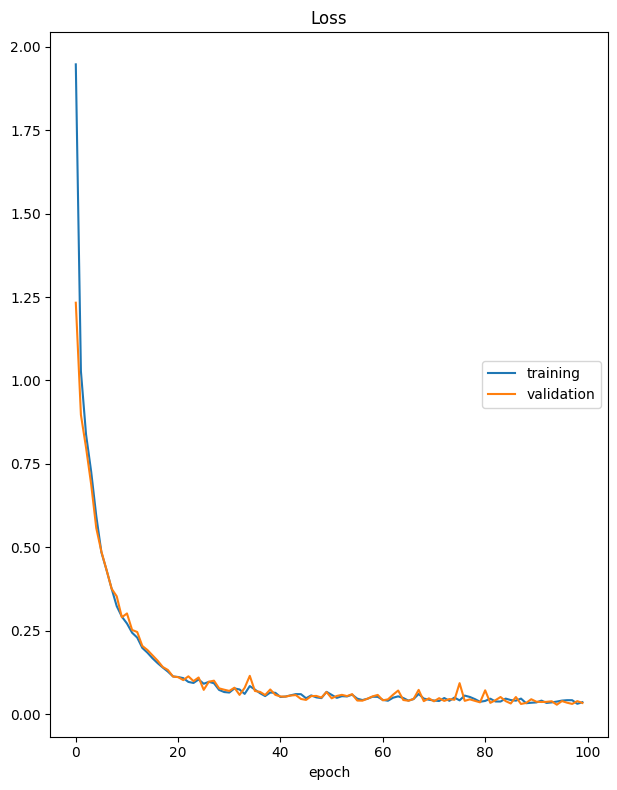

Loss
	training         	 (min:    0.032, max:    1.947, cur:    0.037)
	validation       	 (min:    0.029, max:    1.233, cur:    0.034)
34/34 [==============================] - 0s 9ms/step - loss: 0.0367 - val_loss: 0.0344


In [22]:
# Define the early stopping object
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=15, mode='min')

# Compile the model
model.compile(optimizer='adam', loss='mae')

# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_targets, epochs=100, batch_size=128, validation_split=0.15, verbose=True, callbacks=[PlotLossesKeras()])

In [23]:
# Evaluate the model on the test set
model.evaluate(test_data, test_targets, verbose=2)*180/3.14

40/40 - 0s - loss: 0.0333 - 118ms/epoch - 3ms/step


1.9072005228631814

In [31]:
print(np.around(model.predict([[0,2,1.56],[2,0,0],[1,1,1.56],[1.4,1.3,0.8],[-1,-1,4.6],[1.4,1.4,0.785]])*180/3.14,1))

1/1 [==============================] - 0s 33ms/step
[[ 86.3   2.3]
 [ -2.9   8.6]
 [  0.2  91.4]
 [ 37.2  12.3]
 [180.   84.5]
 [ 43.3   6.6]]


In [32]:
model.save(f"models/invkine_model.h5")

/home/beedo/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


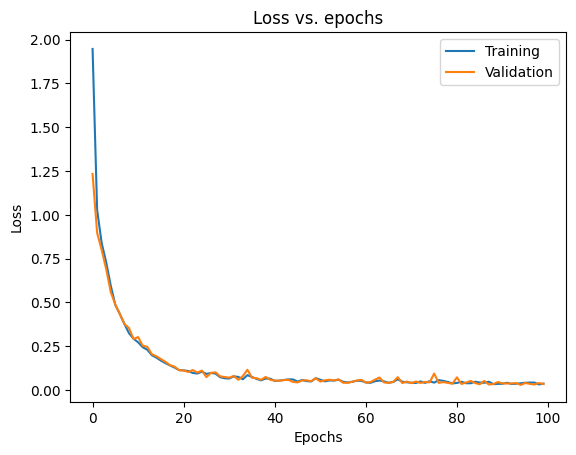

In [33]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()